In [159]:
import numpy as np
from skimage import data, io, filters,util,segmentation,feature,color
import scipy
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from matplotlib import rcParams
%matplotlib inline
import os

gray = plt.get_cmap('gray')


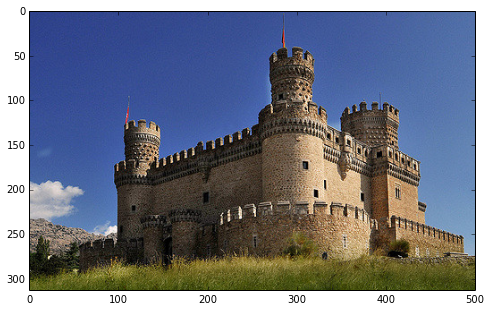

In [250]:
img1 = (io.imread('Images/Q3/castle.jpg',dtype='float64')/255.0)
img2 = (io.imread('Images/Q3/castle2.jpg',dtype='float64')/255.0)


plt.imshow(img1)
plt.show()

### Q3.5


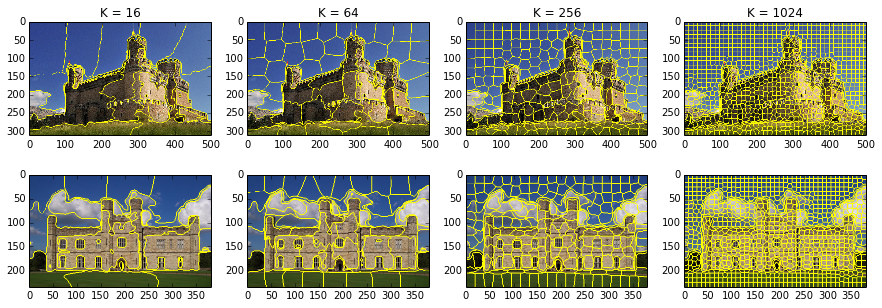

In [253]:
seg1 = segmentation.slic(img1,n_segments = 16, sigma = 3,convert2lab=True,compactness=10)
seg2 = segmentation.slic(img1,n_segments = 64, sigma = 3,convert2lab=True,compactness=10)
seg3 = segmentation.slic(img1,n_segments = 256, sigma = 3,convert2lab=True,compactness=10)
seg4 = segmentation.slic(img1,n_segments = 1024, sigma = 3,convert2lab=True,compactness=10)

seg2_1 = segmentation.slic(img2,n_segments = 16, sigma = 3,convert2lab=True,compactness=10)
seg2_2 = segmentation.slic(img2,n_segments = 64, sigma = 3,convert2lab=True,compactness=10)
seg2_3 = segmentation.slic(img2,n_segments = 256, sigma = 3,convert2lab=True,compactness=10)
seg2_4 = segmentation.slic(img2,n_segments = 1024, sigma = 3,convert2lab=True,compactness=10)


rcParams['figure.figsize'] = 15, 5


fig, axes = plt.subplots(nrows=2,ncols=4)
axes[0,0].set_title('K = 16')
axes[0,1].set_title('K = 64')

axes[0,2].set_title('K = 256')

axes[0,3].set_title('K = 1024')


axes[0,0].imshow(segmentation.mark_boundaries(img1, seg1))
axes[0,1].imshow(segmentation.mark_boundaries(img1, seg2))

axes[0,2].imshow(segmentation.mark_boundaries(img1, seg3))
axes[0,3].imshow(segmentation.mark_boundaries(img1, seg4))

axes[1,0].imshow(segmentation.mark_boundaries(img2, seg2_1))
axes[1,1].imshow(segmentation.mark_boundaries(img2, seg2_2))

axes[1,2].imshow(segmentation.mark_boundaries(img2, seg2_3))
axes[1,3].imshow(segmentation.mark_boundaries(img2, seg2_4))
plt.show()


In [6]:
timeit segmentation.slic(img1,n_segments = 16, sigma = 3,convert2lab=True,compactness=5)

1 loops, best of 3: 209 ms per loop


In [7]:
timeit segmentation.slic(img1,n_segments = 64, sigma = 3,convert2lab=True,compactness=5)

1 loops, best of 3: 215 ms per loop


In [8]:
timeit segmentation.slic(img1,n_segments = 256, sigma = 3,convert2lab=True,compactness=5)

1 loops, best of 3: 230 ms per loop


In [9]:
timeit segmentation.slic(img1,n_segments = 1024, sigma = 3,convert2lab=True,compactness=5)

1 loops, best of 3: 249 ms per loop


### Q3.6


In [152]:
def segmentedPixels(img, seg):
    imgNew = np.zeros(img.shape)
    for i in np.unique(seg):
        mean = np.mean(img[np.where(seg==i)],axis=0)
        imgNew[np.where(seg==i)] = mean
    return imgNew

In [51]:
imgNew_1 = segmentedPixels(img1,seg1)
imgNew_2 = segmentedPixels(img1,seg2)
imgNew_3 = segmentedPixels(img1,seg3)
imgNew_4 = segmentedPixels(img1,seg4)


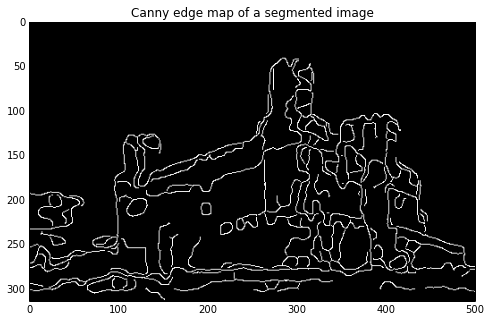

In [255]:
edgeImg1 = feature.canny(color.rgb2gray(imgNew_1))
edgeImg2 = feature.canny(color.rgb2gray(imgNew_2))
edgeImg3 = feature.canny(color.rgb2gray(imgNew_3))
edgeImg4 = feature.canny(color.rgb2gray(imgNew_4))
plt.title('Canny edge map of a segmented image ')
plt.imshow(edgeImg4,cmap = gray)

### Q2.6 Calculating Recall
Recall is a value which gives an indication of how many of the correct categories (in this case edge or not an edge) were identified. The function getRecall calculates this value by by comparing the edges obtained from the self computed segmented image against the ground truth edge map of the image. An edge point at a maximum distance of 3pixels from the ground truth edge point is considered true positive.


In [153]:
def expand3px(sGT):
    ls = list(sGT)
    ls2 = list(ls)
    for pt in ls:
        ptx,pty = pt
        for i in range(-3,4):
            for j in range(-3,4):
                if( (abs(i)+abs(j))>3):
                    continue
                ls2.append((ptx+i,pty+j))
    return frozenset(ls2)

#precision = tp/(tp+fp)
#recall = tp/(tp+fn)
def getRecall(img,edgeGT,K):
    
    tp=0.0;
    fp=0.0;
    fn = 0.0;
    #edgeGT = feature.canny(color.rgb2gray(img));
    imgGTNonzeropts = np.where(edgeGT>0)
    sGT = frozenset(zip(imgGTNonzeropts[0],imgGTNonzeropts[1]))
    sGT3p = expand3px(sGT)
    seg = segmentation.slic(img,n_segments = K, sigma = 3,convert2lab=True,compactness=10)
    imgNew = segmentedPixels(img,seg)
    edgeImg = feature.canny(color.rgb2gray(imgNew))

    imgNonzeropts = np.where(edgeImg>0)
    sImg = frozenset(zip(imgNonzeropts[0],imgNonzeropts[1]))
    tp = float(len(sImg.intersection(sGT3p)))
    fp = float(len(sImg)-tp)
    fn = float(len(sGT) - tp)
    recall = (tp/(tp+fn))

    return recall

### Q2.7 Under measure
This function obtains the set of common pixels between all ground truth segments and calculated segments. It then returns the sum of the minimum between this intersection and the left out pixels of the calculated segment (across all ground truth, calc segment pairs).

In [256]:

def underMeasure(segGT,seg):
    for sG in np.unique(segGT):
        sGTpts = np.where(segGT==sG)
        #print sGTpts
        stGT = frozenset(zip(sGTpts[0],sGTpts[1]))
        u = 0
        for p in np.unique(seg):
            spPts = np.where(seg==p)
            stSP = frozenset(zip(spPts[0],spPts[1]))
            inter = stSP.intersection(stGT)
            u += min(len(inter),len(stSP)-len(inter));
        return u

### Loading BSDS images

In [204]:
## read in image files in all subfolders
#img_types = ['.tif', '.jpg',  '.bmp']
root_folder = "Images/Q3/BSDS/"
image_names = os.listdir(root_folder)

#IMG_PATHS = [[IMG_ROOT + "Q{0}/".format(i+1) + IMG_NAMES[i][j] for j in range(len(IMG_NAMES[i]))] for i in range(len(IMG_NAMES))]
img_jpg_names = [image_names[i] for i in range(len(image_names)) if (image_names[i])[-4:]=='.jpg' ]
imgs_jpgs = [io.imread(root_folder+image_names[i],dtype='float64')/255.0 for i in range(len(image_names)) if (image_names[i])[-4:]=='.jpg' ]


In [230]:
imgs_segs = []
imgs_edges = []
for i,name in enumerate(img_jpg_names):
    imgs_segs.append([io.imread(root_folder+name[:-4]+'_s'+str(j)+'.tif') for j in range(1,6)])
    imgs_edges.append([io.imread(root_folder+name[:-4]+'_e'+str(j)+'.bmp') for j in range(1,6)])


### Q2.8

In [237]:
uArr = []
recallArr = []
for k in [16,64,256,1024]:
    uGlobal = 0.0
    recallGlobal = 0.0
    for i,name in enumerate(img_jpg_names):
        im = imgs_jpgs[i]
        seg = segmentation.slic(im,n_segments = k, sigma = 3,convert2lab=True,compactness=10)
        u = 0
        recall = 0
        for j in range(0,5):
            u += underMeasure(imgs_segs[i][j],seg)
            recall += getRecall(im,imgs_edges[i][j],k)
        u = float(u)/5.0
        recall = float(recall)/5.0
        uGlobal += u
        recallGlobal += recall
    
    
    recallArr.append(recallGlobal/50.0)
    uArr.append(uGlobal/50.0)
    
        
    

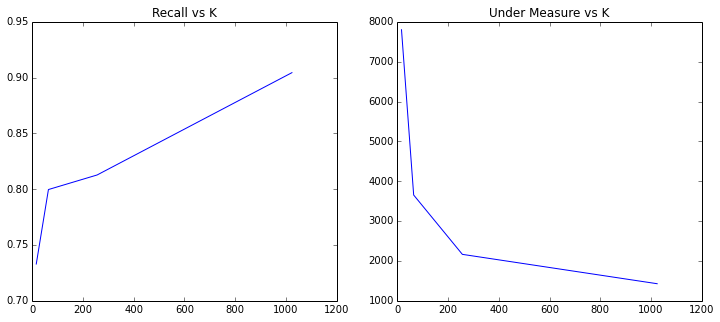

In [249]:
rcParams['figure.figsize'] = 12, 5


fig, axes = plt.subplots(nrows=1,ncols=2)
axes[0].set_title('Recall vs K')
axes[1].set_title('Under-Segmentation Measure vs K ')
axes[0].plot([16,64,256,1024],recallArr)

axes[1].plot([16,64,256,1024],uArr)

plt.show()
